In [28]:
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np
import nibabel as nib
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
import os
from reload_recursive import reload_recursive
from pyprocessmacro import Process
from statsmodels.stats.mediation import Mediation
from statsmodels.miscmodels.ordinal_model import OrderedModel
import sys
import re

from mri_data import file_manager as fm

sys.path.append("/home/srs-9/Projects/ms_mri/analysis/paper1")

import helpers

### Paths and Config

In [29]:
drive_root = fm.get_drive_root()
msmri_home = Path("/home/srs-9/Projects/ms_mri")
msmri_datadir = msmri_home / "data"
curr_dir = Path(os.getcwd())
data_dir = curr_dir / "data0"
cp_data_dir = Path("/home/srs-9/Projects/ms_mri/analysis/paper1/data0")
showfigs = False
pd.options.display.precision = 3

In [30]:
thomas_dir = drive_root / "srs-9/hipsthomas/sub1001-20170215"
thomL_file = thomas_dir / "left/thomasfull_L.nii.gz"
thomL_img = nib.load(thomL_file)
thomL = thomL_img.get_fdata()
thomR_file = thomas_dir / "right/thomasfull_R.nii.gz"
thomR_img = nib.load(thomR_file)
thomR = thomR_img.get_fdata()
thom = thomL_img.get_fdata() + thomR_img.get_fdata()

In [31]:
df_thomas = pd.read_csv(data_dir / "hipsthomas_vols.csv", index_col="subid")
new_colnames = {}
for col in df_thomas.columns:
    new_col = re.sub(r"(\d+)-([\w-]+)", r"\2_\1", col)
    new_col = re.sub("-", "_", new_col)
    new_colnames[col] = new_col
df_thomas = df_thomas.rename(columns=new_colnames)
df_thomas_norm = df_thomas.apply(lambda x: x / df_thomas['THALAMUS_1'])
df_thomas_norm = df_thomas_norm.drop("THALAMUS_1", axis=1)
df_thomas_z = df_thomas.apply(stats.zscore, nan_policy="omit")
df_thomas_norm_z = df_thomas_norm.apply(stats.zscore, nan_policy="omit")
cols_orig = df_thomas.columns

thalamic_nuclei = df_thomas.columns[1:11]

In [32]:
new_index = []
for col in df_thomas.columns:
    new_index.append(int(re.match(r".+_(\d+)$", col)[1]))

df_structs = pd.DataFrame({'struct': df_thomas.columns}, index=new_index)

In [33]:
df = pd.read_csv(cp_data_dir / "t1_aschoplex_data_full.csv", index_col="subid")
df_full = df.copy()
df_tmp = pd.read_csv(cp_data_dir / "t1_data_full.csv", index_col="subid")
df['pineal_volume'] = df_tmp['pineal_volume']
df['pituitary_volume'] = df_tmp['pituitary_volume']
df = pd.concat((df, pd.get_dummies(df["sex"], dtype="int")), axis=1)
df = helpers.set_dz_type5(df)

numeric_vars = ["choroid_volume", "pineal_volume", "pituitary_volume", "Female", "age", "tiv"]
keep_cols = numeric_vars + ["dz_type5"]
df = df[keep_cols]
df_z = df.copy()
df_z[numeric_vars] = df[numeric_vars].apply(stats.zscore, nan_policy="omit")

In [34]:
model_data = df_z.join(df_thomas_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

structs = thalamic_nuclei
for struct in structs:
    formula = f"choroid_volume ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

print(regression_results)

      struct   coef      pvals      p_fdr  coef_sig
12  MD_Pf_12 -0.444  7.392e-20  7.392e-19    -0.444
8      Pul_8 -0.444  1.750e-19  8.752e-19    -0.444
11     CM_11 -0.406  4.286e-15  1.429e-14    -0.406
10    MGN_10 -0.391  4.157e-14  1.039e-13    -0.391
9      LGN_9 -0.341  3.374e-13  6.748e-13    -0.341
7      VPL_7 -0.272  1.452e-07  2.420e-07    -0.272
2       AV_2 -0.271  3.688e-07  5.269e-07    -0.271
6      VLP_6 -0.268  1.077e-06  1.347e-06    -0.268
4       VA_4 -0.120  4.330e-02  4.811e-02    -0.120
5      VLa_5 -0.110  5.541e-02  5.541e-02     0.000


### Overlay betas on label map

In [12]:
beta_map = np.zeros_like(thom)
for lab in np.unique(thom):
    try:
        beta_map[thom==lab] = regression_results.loc[lab, 'coef_sig']
    except KeyError:
        print(lab)
        continue

betamap_img = nib.Nifti1Image(beta_map, thomL_img.affine)
nib.save(betamap_img, thomas_dir/"betamap_sig.nii.gz")

0.0


### Use normed volumes

In [30]:
model_data = df_z.join(df_thomas_norm_z)
covariates = "age + Female + tiv"

pvals = {}
coefs = {}

structs = thalamic_nuclei
for struct in structs:
    formula = f"choroid_volume ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

print(regression_results)

      struct   coef      pvals      p_fdr  coef_sig
8      Pul_8 -0.307  1.721e-13  4.302e-13    -0.307
9      LGN_9 -0.131  1.017e-03  2.033e-03    -0.131
2       AV_2 -0.111  1.312e-02  1.640e-02    -0.111
12  MD_Pf_12 -0.107  9.174e-03  1.529e-02    -0.107
11     CM_11 -0.004  9.303e-01  9.303e-01     0.000
7      VPL_7  0.101  1.537e-02  1.707e-02     0.101
10    MGN_10  0.104  1.244e-02  1.640e-02     0.104
6      VLP_6  0.325  1.205e-14  4.018e-14     0.325
5      VLa_5  0.369  2.999e-19  1.500e-18     0.369
4       VA_4  0.398  2.038e-22  2.038e-21     0.398


In [ ]:
beta_map = np.zeros_like(thom)
for lab in np.unique(thom):
    try:
        beta_map[thom==lab] = regression_results.loc[lab, 'coef']
    except KeyError:
        print(lab)
        continue

betamap_img = nib.Nifti1Image(beta_map, thomL_img.affine)
nib.save(betamap_img, thomas_dir/"betamap_normed.nii.gz")

0.0


### Control for thalamus volume

In [23]:
model_data = df_z.join(df_thomas_z)
model_data = model_data[model_data['dz_type5'].isin(["RMS", "PMS"])]
covariates = "age + Female + tiv + THALAMUS_1"

pvals = {}
coefs = {}

# structs = df_thomas_z.columns[~df_thomas_z.columns.isin(["THALAMUS_1"])]
structs = thalamic_nuclei
for struct in structs:
    formula = f"choroid_volume ~ {struct} + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[struct] = res.pvalues[struct]
    coefs[struct] = res.params[struct]

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
regression_results.insert(0, "struct", regression_results.index)
new_index = []
for item in regression_results.struct:
    new_index.append(int(re.match(r".+_(\d+)$", item)[1]))

for i, row in regression_results.iterrows():
    if row['p_fdr'] < 0.05:
        regression_results.loc[i, 'coef_sig'] = row['coef']
    else:
        regression_results.loc[i, 'coef_sig'] = 0

regression_results.index = new_index
regression_results

print(regression_results)

      struct   coef      pvals      p_fdr  coef_sig
12  MD_Pf_12 -0.299  6.286e-03  1.257e-02    -0.299
8      Pul_8 -0.290  2.077e-02  2.967e-02    -0.290
11     CM_11 -0.176  9.481e-03  1.580e-02    -0.176
10    MGN_10 -0.115  1.246e-01  1.385e-01     0.000
9      LGN_9 -0.112  6.668e-02  8.335e-02     0.000
2       AV_2  0.049  4.502e-01  4.502e-01     0.000
5      VLa_5  0.245  1.032e-04  3.439e-04     0.245
7      VPL_7  0.255  1.701e-03  4.251e-03     0.255
4       VA_4  0.346  6.360e-07  6.360e-06     0.346
6      VLP_6  0.440  2.109e-06  1.055e-05     0.440


In [ ]:
beta_map = np.zeros_like(thom)
for lab in np.unique(thom):
    try:
        beta_map[thom==lab] = regression_results.loc[lab, 'coef']
    except KeyError:
        print(lab)
        continue

betamap_img = nib.Nifti1Image(beta_map, thomL_img.affine)
nib.save(betamap_img, thomas_dir/"betamap_thal_nuclei_control.nii.gz")

In [39]:
np.unique(beta_map)

array([-0.2987549 , -0.29021505, -0.1760622 , -0.11484155, -0.11213292,
        0.        ,  0.04924954,  0.244658  ,  0.25477455,  0.3461345 ,
        0.43990578])

In [72]:
model_data = df_z.join(df_thomas_z)
outcomes = df_thomas.columns[~df_thomas.columns.isin(["THALAMUS_1"])]
covariates = "age + Female + tiv + THALAMUS_1"

cols_orig2 = cols_orig[~cols_orig.isin(["1-THALAMUS"])]

pvals = {}
coefs = {}

for outcome in outcomes:
    formula = f"{outcome} ~ choroid_volume + {covariates}"
    res = sm.OLS.from_formula(formula, data=model_data).fit()
    pvals[outcome] = res.pvalues['choroid_volume']
    coefs[outcome] = res.params['choroid_volume']

regression_results = pd.DataFrame({"coef": coefs, "pvals": pvals})
regression_results['p_fdr'] = stats.false_discovery_control(regression_results['pvals'], method='bh')
regression_results = regression_results.sort_values(by="coef", ascending=True)
print(regression_results)

           coef      pvals      p_fdr
CM_11    -0.101  2.903e-03  9.276e-03
Cla_28   -0.082  2.275e-02  5.309e-02
LGN_9    -0.073  6.239e-02  1.310e-01
MD_Pf_12 -0.060  3.092e-03  9.276e-03
Hb_13    -0.054  2.720e-01  3.569e-01
Pul_8    -0.052  4.603e-03  1.208e-02
MGN_10   -0.046  1.427e-01  2.306e-01
Put_31   -0.036  3.358e-01  4.148e-01
Acc_26   -0.032  4.013e-01  4.435e-01
RN_32    -0.005  8.860e-01  8.860e-01
GPe_29    0.020  6.432e-01  6.754e-01
GP_33     0.036  3.856e-01  4.435e-01
AV_2      0.042  2.543e-01  3.560e-01
Amy_34    0.063  2.069e-01  3.104e-01
Cau_27    0.071  1.004e-01  1.758e-01
GPi_30    0.074  9.106e-02  1.738e-01
VPL_7     0.098  4.088e-04  1.726e-03
VLP_6     0.131  4.734e-08  4.970e-07
VLa_5     0.159  9.261e-06  6.482e-05
MTT_14    0.160  4.111e-04  1.726e-03
VA_4      0.189  3.023e-09  6.348e-08


### Estimate exposure of each substructure to CSF

Got aseg from fastsurfer. had to reregister it back to original space. extracted the ventricles only (label indices [here](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT)). Then used c3d -sdt to get the signed distance transform, absed then binned to get below:

In [8]:
from sklearn.cluster import HDBSCAN
from scipy import ndimage
from scipy.spatial import distance

In [41]:
aseg_file = "/mnt/h/srs-9/hips-thomas/sub1001-20170215/aseg-sdt-bin.nii.gz"
aseg = nib.load(aseg_file).get_fdata()
ventricle_points = np.argwhere(aseg==0)

In [42]:
thomas_dir = Path("/mnt/h/srs-9/hips-thomas/sub1001-20170215")
thomL_file = thomas_dir / "left/thomasfull_L.nii.gz"
thomL_img = nib.load(thomL_file)
thomL = thomL_img.get_fdata()

thomR_file = thomas_dir / "right/thomasfull_R.nii.gz"
thomR_img = nib.load(thomR_file)
thomR = thomR_img.get_fdata()
thom = thomL_img.get_fdata() + thomR_img.get_fdata()

In [ ]:
def exposure(centroid, point_set):
    total = 0
    for point in point_set:
        total = total + 1 / (distance.euclidean(centroid, point))**2
    return total

In [44]:
df_exposure = df_structs.copy()
for ind in np.unique(thomL):
    struct_pts = thomL.copy()
    struct_pts[thomL!=ind] = 0
    struct_pts[thomL==ind] = 1

    centroid = ndimage.center_of_mass(struct_pts)
    df_exposure.loc[ind, 'exposure'] = exposure(centroid, ventricle_points)

In [84]:
exposure_map = np.zeros_like(thom)
for lab in np.unique(thom):
    if lab == 0:
        continue
    try:
        if df_exposure.loc[lab, 'exposure'] is None:
            print(lab)
            continue
        exposure_map[thom==lab] = df_exposure.loc[lab, 'exposure']
    except KeyError:
        print(lab)
        continue

exposure_map_img = nib.Nifti1Image(exposure_map, thomL_img.affine)
nib.save(exposure_map_img, thomas_dir/"exposure_map.nii.gz")

In [50]:
df_exposure['coef'] = regression_results['coef']

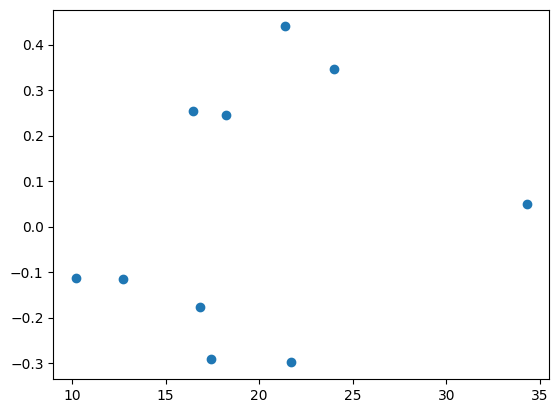

In [51]:
plt.scatter(df_exposure[df_exposure.struct.isin(thalamic_nuclei)].exposure, df_exposure[df_exposure.struct.isin(thalamic_nuclei)].coef)

In [ ]:
centroid_coords = [round(coord) for coord in centroid]
test = thom.copy()
test[*centroid_coords] = 60
test_img = nib.Nifti1Image(test, thomL_img.affine)
nib.save(test_img, thomas_dir/"check.nii.gz")

With choroid sdt

In [35]:
choroid_sdt_file = "/media/smbshare/srs-9/thalamus_project/aschoplex/sub1001-20170215/choroid-sdt-binv.nii.gz"
choroid_sdt = nib.load(choroid_sdt_file).get_fdata()
choroid_points = np.argwhere(choroid_sdt==0)

In [39]:
df_exposure = df_structs.copy()
for ind in np.unique(thomL):
    ind = int(ind)
    struct_pts = thomL.copy()
    struct_pts[thomL!=ind] = 0
    struct_pts[thomL==ind] = 1

    centroid = ndimage.center_of_mass(struct_pts)
    df_exposure.loc[ind, 'exposure'] = exposure(centroid, choroid_points)

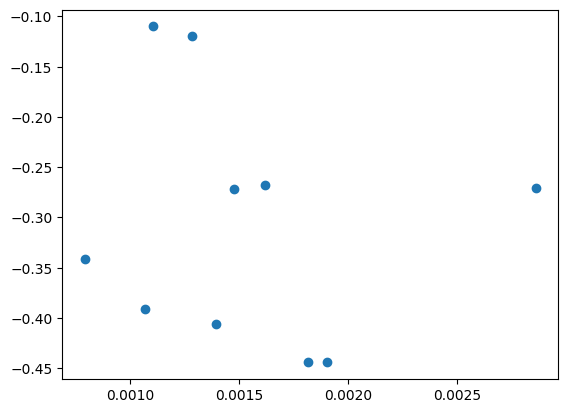

In [40]:
df_exposure['coef'] = regression_results['coef']
plt.scatter(df_exposure[df_exposure.struct.isin(thalamic_nuclei)].exposure, df_exposure[df_exposure.struct.isin(thalamic_nuclei)].coef)

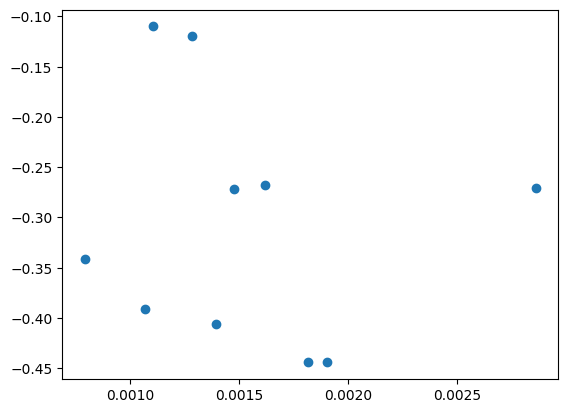

In [50]:
thomas_means = df_thomas.mean()
thomas_means.index = df_structs.index
df_exposure['vols'] = thomas_means
df_exposure['SA'] = thomas_means**(2/3)
df_exposure['exposure2'] = df_exposure['exposure']
plt.scatter(df_exposure[df_exposure.struct.isin(thalamic_nuclei)].exposure2, df_exposure[df_exposure.struct.isin(thalamic_nuclei)].coef)